# Neural Network Training Proess

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Imports & Global variables list:**  
A symbolic link is done to import FastAI v0.7 library, the target folder is named "fastai07"  

NAME: nickname for our model, must match the folder name in DL folder  
INP: Directory where we will read our input file  
DIR: Directory where we'll save model and export our parameters  
cat_vars: List of categorical variables in our model  
cont_vars: List of continous variables in our model  
QP: Quantization Parameter  
Layers: Number of neurons per hidden layer in our network  
Dropouts: Percentage of dropout rate per hidden layer  
BN_use: Use batch normalization if set to True  

In [2]:
from fastai07.structured import *
from fastai07.column_data import *

NAME='blowing'
INP='./DL'
DIR='./DL/{0}'.format(NAME)
cat_vars = ['Height', 'Width']
cont_vars = ['top_left', 'top_center', 'top_right', 'left', 'center', 'right', 
             'bottom_left', 'bottom_center', 'bottom_right']
maplist = [['top_left', 0], ['top_center', 1], ['top_right', 2], ['left', 3], ['center', 4], ['right', 5], 
         ['bottom_left', 6], ['bottom_center', 7], ['bottom_right', 8]]
QP=22
Layers=[30, 30]
Dropouts=[0.001, 0.01]
BN_use=True

**Helper Functions**:  
In FastAI v0.7, there's a proc_df() function that does the following:  
1) Splits dependent variable "output" from the dataframe  
2) Normalizes the continuous variables  
3) Returns a mapper that holds the mean and std for normalization  
4) Categorizes the categorical variables  
5) Handles missing values  

This function will be used in read_proc() process our data. Note that we don't have any missing values.

In [3]:
# Read, normalize, and process Inputs and Outputs
def read_proc():
    df = pd.read_csv('{0}/SSE_{1}.csv'.format(INP, QP), names=cont_vars+cat_vars+['y'], nrows=10e6)
    for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    for v in cont_vars: df[v] = df[v].astype('float32')
    df, y, nas, mapper = proc_df(df, 'y',do_scale=True)
    del nas
    for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    for v in cont_vars: df[v] = df[v].astype('float32')
    cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]
    # Rule of Thumb for embedding sizes "taken from FastAI course 2018"
    emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
    val_idx = get_cv_idxs(len(df), val_pct=0.2)
    return df, y, mapper, emb_szs, val_idx

# Export the Mean and STDev
# The target folder is: ./$DIR/$QP/
def export_mapper():
    mapper_df = pd.DataFrame(index=['mean', 'std'], columns=cont_vars)
    for column,i in maplist:
        mapper_df[column].loc['mean'] = np.float64(mapper.features[i][1].mean_)
        mapper_df[column].loc['std'] = np.float64(np.sqrt(mapper.features[i][1].var_))

    mapper_df.to_csv('{0}/{1}/mapper_{1}.csv'.format(DIR, QP), index=False, header=None, line_terminator=";\n")
    return

# Process and Save model
# The saved model is in the format: QP{qp}_{name}_{accuracy}
def save_model():
    log_preds, targs = m.predict_with_targs()
    preds = np.argmax(log_preds, axis=1)
    right = 0
    for i in range (len(preds)):
        if(preds[i] == targs[i]):
            right += 1
    acc = (right / len(preds)) * 100
    print("Validation accuracy: ", acc)
    name = "QP{0}_{1}_acc{2}".format(QP, NAME, round(acc, 2))
    m.save(name)
    return

# Export Weights and Biases for each layer
# The target folder is: ./$DIR/$QP/
def export_parameters():
    for i in range(len(m.model.bns)):
        pd.DataFrame(m.model.bns[i].weight.data.numpy()).to_csv('{0}/{1}/bns{2}-weight.csv'.format(DIR, QP, i), 
                                                                index=False, header=None , line_terminator=", ")
        pd.DataFrame(m.model.bns[i].bias.data.numpy()).to_csv('{0}/{1}/bns{2}-bias.csv'.format(DIR, QP, i), 
                                                              index=False, header=None , line_terminator=", ")
    for i in range(len(m.model.lins)):
        pd.DataFrame(m.model.lins[i].weight.data.numpy()).to_csv('{0}/{1}/lins{2}-weight.csv'.format(DIR, QP, i), 
                                                                 index=False, header=None, line_terminator=",\n")
        pd.DataFrame(m.model.lins[i].bias.data.numpy()).to_csv('{0}/{1}/lins{2}-bias.csv'.format(DIR, QP, i), 
                                                               index=False, header=None, line_terminator=", ")
    for i in range(len(m.model.embs)):
        pd.DataFrame(m.model.embs[i].weight.data.numpy()).to_csv('{0}/{1}/emb{2}-weight.csv'.format(DIR, QP, i), 
                                                                index=False, header=None, line_terminator=",\n")
    pd.DataFrame(m.model.outp.weight.data.numpy()).to_csv('{0}/{1}/outp-weight.csv'.format(DIR, QP), 
                                                          index=False, header=None, line_terminator=",\n")
    pd.DataFrame(m.model.outp.bias.data.numpy()).to_csv('{0}/{1}/outp-bias.csv'.format(DIR, QP), index=False, 
                                                        header=None, line_terminator=", ")
    pd.DataFrame(m.model.bn.weight.data.numpy()).to_csv('{0}/{1}/bn-weight.csv'.format(DIR, QP), index=False, 
                                                        header=None, line_terminator=", ")
    return

In [4]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

# class BinaryTanh(nn.Module):
#     def __init__(self):
#         super(BinaryTanh, self).__init__()
#         self.hardtanh = nn.Hardtanh()

#     def forward(self, input):
#         output = self.hardtanh(input)
#         output = Binarize(output)
#         return output
        

class BinaryLinear(nn.Linear):

    def forward(self, input):
#         if input.size(1) != 17:
#             input.data = Binarize(input.data)
        binary_weight = Binarize(self.weight)
        if self.bias is None:
            return F.linear(input, binary_weight)
        else:
            return F.linear(input, binary_weight, self.bias)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv

# class BinarizeLinear(nn.Linear):

#     def __init__(self, *kargs, **kwargs):
#         super(BinarizeLinear, self).__init__(*kargs, **kwargs)

#     def forward(self, input):

#         if input.size(1) != 784:
#             input.data=Binarize(input.data)
#         if not hasattr(self.weight,'org'):
#             self.weight.org=self.weight.data.clone()
#         self.weight.data=Binarize(self.weight.org)
#         out = nn.functional.linear(input, self.weight)
#         if not self.bias is None:
#             self.bias.org=self.bias.data.clone()
#             out += self.bias.view(1, -1).expand_as(out)

#         return out

In [11]:
class BinaryModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        if is_reg==False and is_multi==False: assert out_sz >= 2, "For classification with out_sz=1, use is_multi=True"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            BinaryLinear(szs[i], szs[i+1]) for i in range(len(szs)-1)])    # UPDATED
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = BinaryLinear(szs[-1], out_sz)    # UPDATED
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = Binarize(x)  # UPDATED
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x2 = Binarize(x2)  # UPDATED
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
#         for l,d,b in zip(self.lins, self.drops, self.bns):
#             x = BinaryTanh(l(x))
#             if self.use_bn: x = b(x)
#             x = d(x)

        # UPDATED # UPDATED
        for l,d, b in zip(self.lins, self.drops, self.bns):
            x = l(x)
            if self.use_bn: x = b(x)
            x = F.hardtanh(x, inplace=True)
            x = d(x)
        # END OF UPDATE
        
        x = self.outp(x)
#         if not self.is_reg:
#             if self.is_multi:
#                 x = F.sigmoid(x)
#             else:
#                 x = F.log_softmax(x)
#         elif self.y_range:
#             x = F.sigmoid(x)
#             x = x*(self.y_range[1] - self.y_range[0])
#             x = x+self.y_range[0]
        return x

In [12]:
class ColumnarBinaryData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)
        
    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        trn_ds  = ColumnarDataset.from_data_frame(trn_df,  cat_flds, trn_y, is_reg, is_multi)
        val_ds  = ColumnarDataset.from_data_frame(val_df,  cat_flds, val_y, is_reg, is_multi)
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None,  is_reg, is_multi) if test_df is not None else None
        return cls(path, trn_ds, val_ds, bs, test_ds=test_ds, shuffle=shuffle)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df, shuffle=shuffle)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = BinaryModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [7]:
if 'df' in globals(): del df, y, mapper
df, y, mapper, emb_szs, val_idx = read_proc()

In [13]:
md = ColumnarBinaryData.from_data_frame(INP, val_idx, df, y, cat_flds=cat_vars, 
                                       bs=1024, is_multi=False, is_reg=False)
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                   0.001, 49, Layers, Dropouts, use_bn=BN_use)

In [14]:
m.crit = nn.CrossEntropyLoss()

epoch      trn_loss   val_loss                                
    0      6.410926   6.483352  



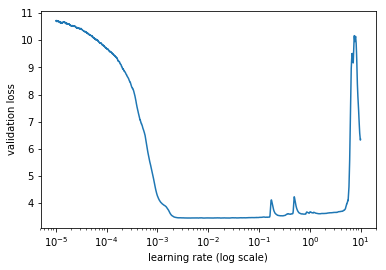

In [15]:
m.lr_find()
m.sched.plot()

In [16]:
LR = 1e-3
m.fit(LR, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      3.454084   3.451232   0.09553   



[array([3.45123]), 0.0955295]

In [ ]:
m.model

In [ ]:
Binarize(m.model.lins[0].weight)

In [ ]:
m.model.lins[0].bias

In [17]:
log_preds, targs = m.predict_with_targs()
preds = np.argmax(log_preds, axis=1)

In [18]:
mp = np.zeros(49, dtype=np.uint)
for pred in preds:
    mp[pred] += 1

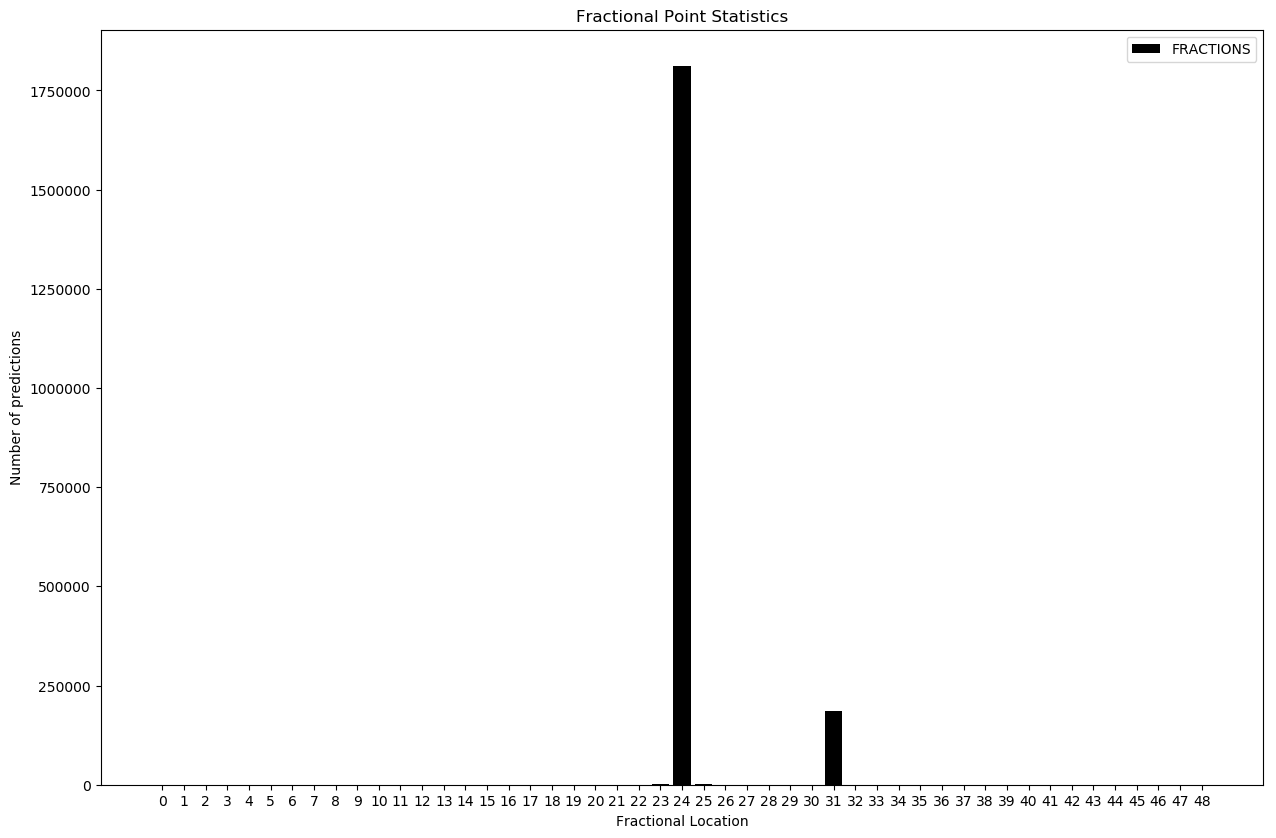

In [20]:
fig = plt.figure(num=1, figsize=(15, 10), dpi=100)
plt.bar(np.arange(0, 49, 1), mp, width=0.8, color='k', label="FRACTIONS")
plt.title("Fractional Point Statistics")
plt.xlabel("Fractional Location")
plt.ylabel("Number of predictions")
plt.xticks(np.arange(0, 49, 1))
plt.legend()
plt.show()

In [ ]:
import seaborn

In [ ]:
plt.figure(figsize=(10,7))
plt.matshow(sklearn.metrics.confusion_matrix(targs, preds))
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
seaborn.heatmap(sklearn.metrics.confusion_matrix(targs, preds))

## Deep Learning

First, we read and process our input:

In [ ]:
if 'df' in globals(): del df, y, mapper
df, y, mapper, emb_szs, val_idx = read_proc()
# Optional: export mapper for inference
# export_mapper()

Create ModelData and Learner objects  
The problem we're dealing with is a multi-class classification "output is one of 49 fractional locations", so in get_learner() function, we set is_multi= and is_reg= to False  


In [ ]:
md = ColumnarModelData.from_data_frame(INP, val_idx, df, y, cat_flds=cat_vars, 
                                       bs=1024, is_multi=False, is_reg=False)
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                   0.001, 49, Layers, Dropouts, use_bn=BN_use)
# Optional: Load previously saved model
# m.load('QP22_blowing_200_train_acc36.51')

Run learning Rate Finder:  
Plots the error for each learning rate, we choose the learning rate before the error starts flattening out "in our case, usually learning rate = 1e-3"

In [ ]:
m.lr_find()
m.sched.plot()

Fit the model for a specified number of epochs:

In [ ]:
LR = 1e-2
m.fit(LR, 1, metrics=[accuracy])

Save the model and Export parameters:

In [ ]:
save_model()
export_parameters()

Repeat for other Quantization Parameters:

In [ ]:
for QP in [27, 32, 37]:
    if 'df' in globals(): del df, y, mapper
    df, y, mapper, emb_szs, val_idx = read_proc()
    export_mapper()
    md = ColumnarModelData.from_data_frame(INP, val_idx, df, y, cat_flds=cat_vars, 
                                           bs=1024, is_multi=False, is_reg=False)
    m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                       0.001, 49, Layers, Dropouts, use_bn=BN_use)
    m.fit(LR, 200, metrics=[accuracy])
    save_model()
    export_parameters()